In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import collections
import itertools
import unicodedata
import statsmodels.api as sm
from datetime import date
import seaborn as sns
from ast import literal_eval

/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('data/listings_full.csv')
df = df[df.room_type=='Entire home/apt']

## Remove columns without interest

In [3]:
col_text = ['name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview',\
            'notes','transit','access','interaction','house_rules','host_about']
columns_to_exclude = ['calendar_last_scraped', 'id', 'scrape_id', 'last_scraped', 'listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_thumbnail_url', 'host_picture_url', 'host_total_listings_count','host_acceptance_rate', 'street', 'city', 'state', 'market', 'smart_location', 'country_code', 'country','room_type', 'has_availability','zipcode','neighbourhood','host_neighbourhood','neighbourhood_cleansed', 'requires_license', 'license', 'jurisdiction_names', 'calculated_host_listings_count','square_feet','monthly_price',
'weekly_price','security_deposit','cleaning_fee']

In [4]:
columns_to_exclude

['calendar_last_scraped',
 'id',
 'scrape_id',
 'last_scraped',
 'listing_url',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_location',
 'host_thumbnail_url',
 'host_picture_url',
 'host_total_listings_count',
 'host_acceptance_rate',
 'street',
 'city',
 'state',
 'market',
 'smart_location',
 'country_code',
 'country',
 'room_type',
 'has_availability',
 'zipcode',
 'neighbourhood',
 'host_neighbourhood',
 'neighbourhood_cleansed',
 'requires_license',
 'license',
 'jurisdiction_names',
 'calculated_host_listings_count',
 'square_feet',
 'monthly_price',
 'weekly_price',
 'security_deposit',
 'cleaning_fee']

### Convert host location to country

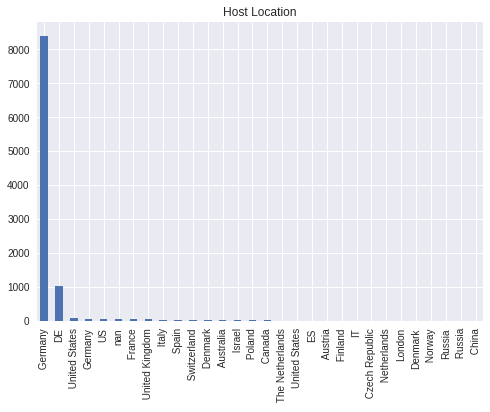

In [5]:
df.host_location = df.host_location.apply(lambda x: str(x).split(',')[-1])
df.host_location.value_counts().sort_values(ascending=False).head(30).plot.bar(title="Host Location")

### Host neighbourhood

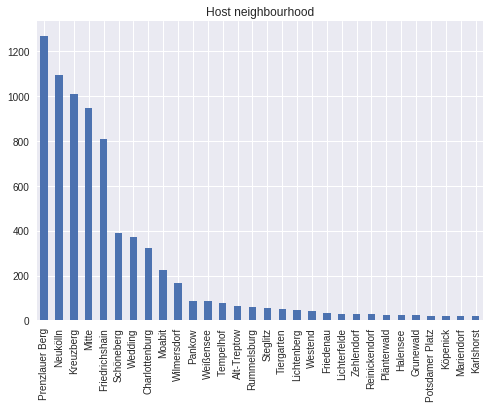

In [6]:
df.host_neighbourhood.value_counts().head(30).plot.bar(title="Host neighbourhood")

### Number of listing per host

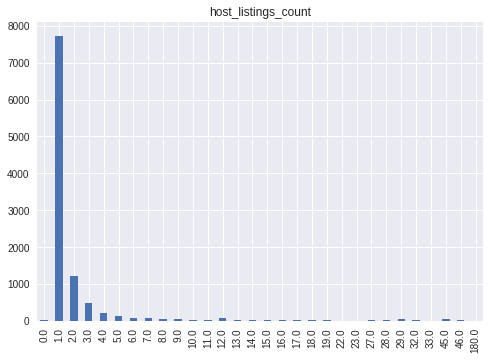

In [7]:
df.host_listings_count.value_counts().sort_index().plot.bar(title="host_listings_count")

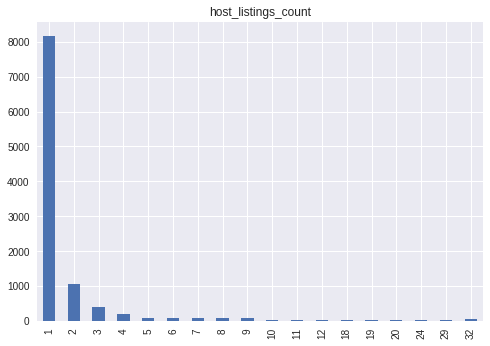

In [8]:
df.calculated_host_listings_count.value_counts().sort_index().plot.bar(title="host_listings_count")

In [9]:
df = df.drop(columns_to_exclude+col_text,axis=1)

### Remove special characters on columns name function

In [10]:
def remove_special_character(df, df_name):
    df.columns  = [''.join(e for e in col if e.isalnum()) for col in df.columns.tolist()]
    df.columns = [df_name+'_'+ col for col in df.columns]
    return df
    

## Split the amenities column into single columns

In [11]:
def convert_to_dict(x):
    x = x.replace('{','').replace('}','')
    x = x.replace('-','_')
    x = x.replace('\"','').replace('\"','')
    x = x.replace('(','').replace(')','')
    x = x.replace('/','').replace(':','_')
    x = x.replace('\'','').replace('.','_')
    
    x = x.split(',')
    return collections.Counter(x)

In [12]:
df.amenities = df.amenities.apply(convert_to_dict)

In [13]:
df_amenities = df.amenities.apply(pd.Series)
df_amenities = remove_special_character(df_amenities,'amenities_')
df_amenities = df_amenities.fillna(0)

In [14]:
df = pd.concat([df,df_amenities],axis=1)
df = df.drop('amenities',axis=1)

## Split the host verification in columns

In [15]:
df.host_verifications.head()

16             ['email', 'phone', 'reviews']
17             ['email', 'phone', 'reviews']
18             ['email', 'phone', 'reviews']
19    ['email', 'phone', 'reviews', 'jumio']
20                        ['email', 'phone']
Name: host_verifications, dtype: object

In [16]:
host_verifications2 = df.host_verifications.apply(lambda x: collections.Counter(literal_eval(x)))
df_host_verifications = host_verifications2.apply(pd.Series)
df_host_verifications.columns = ['host_verification_'+col for col in df_host_verifications.columns.tolist()]
df_host_verifications = df_host_verifications.fillna(0)

In [17]:
df = pd.concat([df,df_host_verifications],axis=1)
df = df.drop('host_verifications',axis=1)

print df.shape

(10285, 165)


## Convert bed type to categories

In [18]:
df_bed_type = pd.get_dummies(df.bed_type)
df_bed_type = remove_special_character(df_bed_type,'bed_type')

In [19]:
df = pd.concat([df,df_bed_type],axis=1)
df = df.drop('bed_type',axis=1)
print df.shape

(10285, 169)


### Convert neighbourhood_group_cleansed to categories

In [20]:
df_neighbourhood_group_cleansed = pd.get_dummies(df.neighbourhood_group_cleansed)
df_neighbourhood_group_cleansed = remove_special_character(df_neighbourhood_group_cleansed,'neighbourhood_group_cleansed_')

In [21]:
df = pd.concat([df,df_neighbourhood_group_cleansed],axis=1)
df = df.drop('neighbourhood_group_cleansed',axis=1)
print df.shape

(10285, 180)


### Convert property_type to categories

In [22]:
df_property_type = pd.get_dummies(df.property_type)
df_property_type = remove_special_character(df_property_type,'property_type_')

In [23]:
df = pd.concat([df,df_property_type],axis=1)
df = df.drop('property_type',axis=1)
print df.shape

(10285, 200)


### Convert cancellation policy to numeric

In [24]:
df.cancellation_policy.unique()

array(['strict', 'flexible', 'moderate', 'super_strict_60'], dtype=object)

In [25]:
df.cancellation_policy = df.cancellation_policy.replace('flexible',0).replace('moderate',1).replace('strict',2).replace('super_strict_60',3)

In [26]:
df.cancellation_policy.value_counts()

2    3670
0    3481
1    3133
3       1
Name: cancellation_policy, dtype: int64

### Convert last update to days

In [27]:
def convert_last_update_to_days(x):
    if 'today' in x:
        return 0
    elif 'yesterday' in x:
        return 1
    elif 'a week ago' in x:
        return 7
    elif 'week' in x:
        return int(x.split(' ')[0])*7
    elif 'month' in x:
        return int(x.split(' ')[0])*30

In [28]:
df.last_update_days = df.calendar_updated.apply(convert_last_update_to_days)

In [29]:
df = df.drop('calendar_updated',axis=1)

### Convert response time to days

In [30]:
df.host_response_time.unique()
df.host_response_time = df.host_response_time.replace({'within a few hours':4,'within a day':24,'within an hour':1,'a few days or more':48})

### Convert response rate to integer

In [31]:
df.host_response_rate = df.host_response_rate.apply(lambda x : float(str(x).strip('%')))


In [32]:
df.host_response_rate.unique()

array([ 100.,   nan,   67.,   50.,   90.,   80.,   72.,   70.,    0.,
         83.,   92.,   88.,   60.,   22.,   97.,   10.,   13.,   71.,
         86.,   30.,   99.,   40.,   75.,   69.,   89.,   17.,   87.,
         98.,   93.,   85.,   96.,   53.,   77.,   20.,   79.,   68.,
         82.,   25.,   84.,   95.,   56.,   94.,   33.,   43.,   54.,
         32.,   91.,   73.,   63.,   65.,   44.,   59.,   14.,   62.,
         78.,   64.,   58.,   55.,   57.,   76.,   29.,   31.,   81.,
         47.,   74.,   38.,   66.,   46.,   23.,    7.])

## Convert price to float

In [33]:
df.price=df.price.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
#df.weekly_price=df.weekly_price.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
#df.monthly_price=df.monthly_price.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
#df.security_deposit=df.security_deposit.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
#df.cleaning_fee=df.cleaning_fee.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)
df.extra_people=df.extra_people.replace( '[\$,)]','', regex=True ).replace( '[(]','-',regex=True ).astype(float)


## Convert boolean to integer

In [34]:
df['host_has_profile_pic']=(df.host_has_profile_pic=='t')*1
df['host_identity_verified']=(df.host_identity_verified=='t')*1
df['is_location_exact']=(df.is_location_exact=='t')*1
df['instant_bookable']=(df.instant_bookable=='t')*1
df['require_guest_profile_picture']=(df.require_guest_profile_picture=='t')*1
df['require_guest_phone_verification']=(df.require_guest_phone_verification=='t')*1
df['host_is_superhost']=(df.host_is_superhost=='t')*1


## Convert last review and first review into numbers of day

In [35]:
df.last_review = date.today()-pd.to_datetime(df.last_review)
df.first_review = date.today()-pd.to_datetime(df.first_review)
df.host_since = date.today()-pd.to_datetime(df.host_since)


df.last_review = df.last_review.apply(lambda x: x / np.timedelta64(1,'D'))
df.first_review = df.first_review.apply(lambda x: x / np.timedelta64(1,'D'))
df.host_since = df.host_since.apply(lambda x: x / np.timedelta64(1,'D'))

### Filter on listings with high reviews number

In [36]:
df = df[~df.last_review.isnull()]
df = df[~df.review_scores_value.isnull()]
df = df[df.number_of_reviews>10]

### Fill the missing data

In [37]:
columns_fill_na_with_mean = [u'bathrooms', u'bedrooms', u'beds', u'host_since',
       u'host_listings_count','host_response_time','host_response_rate']

df[columns_fill_na_with_mean]= df[columns_fill_na_with_mean].fillna(df[columns_fill_na_with_mean].mean())

In [38]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data[df_missing_data.missing_percent>0]

,missing_percent


### Convert special characters in columns name to ascii

In [39]:
df.columns.tolist()

['host_since',
 'host_response_time',
 'host_response_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'latitude',
 'longitude',
 'is_location_exact',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'price',
 'guests_included',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'reviews_per_month',
 'amenities__',
 'amenities__24hourcheckin',
 'amenities__Accessibleheightbed',
 'amenities__Accessibleheighttoilet',
 'amenities__Airconditioning',
 'amenities__BBQgrill',
 'amenities__Bab

### R-like str function

In [40]:
def get_unique(x):
     
    return type(x.values[1]),x.unique()

def rstr(df):
    return df.apply(get_unique)

print(rstr(df))

host_since                                          (<type 'numpy.float64'>, [724.0, 929.0, 970.0,...
host_response_time                                  (<type 'numpy.float64'>, [4.0, 24.0, 1.0, 8.16...
host_response_rate                                  (<type 'numpy.float64'>, [100.0, 93.7265761059...
host_is_superhost                                                (<type 'numpy.float64'>, [0.0, 1.0])
host_listings_count                                 (<type 'numpy.float64'>, [1.0, 2.0, 3.0, 4.0, ...
host_has_profile_pic                                             (<type 'numpy.float64'>, [1.0, 0.0])
host_identity_verified                                           (<type 'numpy.float64'>, [1.0, 0.0])
latitude                                            (<type 'numpy.float64'>, [52.5795812495, 52.58...
longitude                                           (<type 'numpy.float64'>, [13.4026556548, 13.41...
is_location_exact                                                (<type 'numpy.flo

## Correlation with target

In [41]:
df_corr = df.corr()['availability_365']
df_corr = pd.DataFrame(df_corr)
df_corr['corr_abs'] = np.abs(df_corr.availability_365)
df_corr = df_corr.sort_values(by='corr_abs',ascending=False)
df_corr.head(10)

,availability_365,corr_abs
availability_365,1.000000,1.000000
availability_90,0.555810,0.555810
availability_60,0.528417,0.528417
availability_30,0.463514,0.463514
amenities__TV,0.175631,0.175631
review_scores_value,-0.168442,0.168442
last_review,-0.159129,0.159129
reviews_per_month,0.147964,0.147964
review_scores_rating,-0.147767,0.147767
host_listings_count,0.144097,0.144097


## Linear Model and R-squared

In [42]:
X = df.availability_365.values
y = df.drop(['availability_365','availability_30','availability_60','availability_90'],axis=1).values

In [43]:
mod =sm.OLS(endog=X,exog=y)

In [ ]:
res = mod.fit()
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     5.321
Date:                Thu, 13 Jul 2017   Prob (F-statistic):           1.35e-84
Time:                        13:59:26   Log-Likelihood:                -19093.
No. Observations:                3132   AIC:                         3.853e+04
Df Residuals:                    2960   BIC:                         3.957e+04
Df Model:                         171                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0054      0.005     -1.100      0.2

/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/home/ramon/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ramon/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ramon/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


### AIC step

In [ ]:
colos = df.columns.tolist()

colos = set(colos)- set(['availability_30', 'availability_60', 'availability_90', 'availability_365'])
predictorcols = colos
AICs = {}
for k in range(1,len(predictorcols)+1):
    for variables in itertools.combinations(predictorcols, k):
        predictors = df[list(variables)]
        predictors['Intercept'] = 1
        res = sm.OLS(predictors, X).fit()
        AICs[variables] = 2*(k+1) - 2*res.llf
pd.Series(AICs).idxmin()

/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
